---
# Writeup: Advanced Lane Finding

## Udacity - Self Driving Car Nanodegree Project



---

#### In the course of this project, the following steps were completed:

* Camera calibration
* Distortion correction
* Creation of a thresholded binary image using color transform and gradients
* Perspective transform (Warp)
* Identification of lane-line pixels and polynomial fit
* Curve radius and offset calculation
* Creating an overlay with the detected lane

---

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from help_func import draw_lines_from_points, show_img, show_imgs, create_comb_img
import pickle
from collections import deque
%matplotlib inline

In [2]:
# read image and determine number of rows, columns and color channels for all images used in this project
img = mpimg.imread('test_images/test1.jpg')
rows, cols, channels = img.shape

## Camera calibration

For distortion correction of an image, the camera matrix and distortion coefficients are required. They are calculated using the openCV function `cv2.calibrateCamera()` (*code cell 3, line 31*), which takes real world 3D object points (x,y,z) and 2D image points (x,y) of the calibration pattern as input arguments.

Since the use of more than 10 calibration images is recommended ([openCV documentation](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html)), all of the provided 20 images are used. The respective object and image points of the individual images are simply appended and then passed to the calibration function.

Since the chessboard pattern is assumed to be fixed at the (x,y) plane at z=0, the object points for all 9x6 calibration images defined as $(0,0,0), (1,0,0), ... (8,5,0)$ (*code cell 3, line 1-5*).
The image points are determinded by the `cv2.findChessboardCorners()` (*code cell 3, line 20*), which outputs the 2D-coordinates of all chessboard corners from the input image.

Distorted images taken with the same camera can now be corrected by using the `cv2.undistort()` function, which takes the calibration matrix and distortion coefficients as input arguments. It is used in *code cell 3, line 33*. The output is provided below.

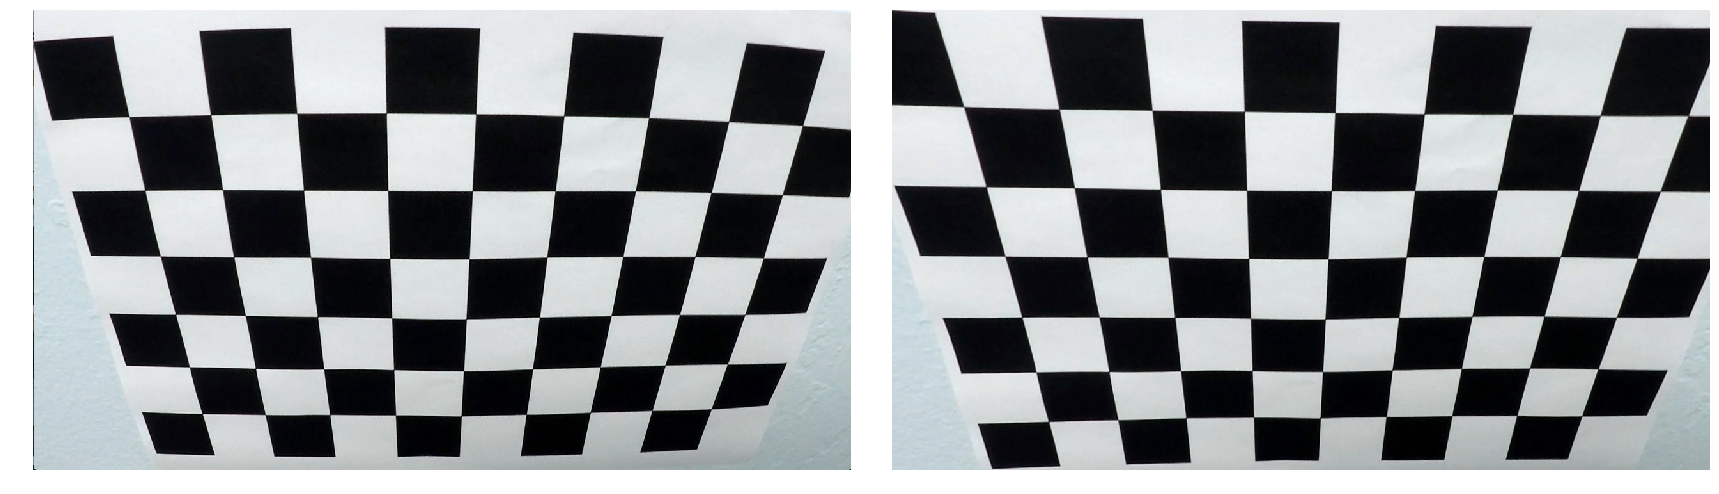

In [3]:
# initialize array for object points with dimensions (6*9, 3)
objp = np.zeros((6*9,3), np.float32)
# create mesh grid for x and y components, transpose and reshape to get an (6*9, 2) array 
# (z component is assumed to be 0)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# initialize arrays for object- and image points from all calibration images
objpts = [] # 3D points in real world space
imgpts = [] # 2D points in image plane

# get list of all available calibration images
cal_images = glob.glob('camera_cal/calibration*.jpg')

# find chessboard corners in all images
for idx, img_name in enumerate(cal_images):
    img = cv2.imread(img_name) # read image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    
    # find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    # if corners were found, object- and image points are added
    if ret == True:
        objpts.append(objp)
        imgpts.append(corners)

        cv2.drawChessboardCorners(img, (9,6), corners, ret)        

dist_img = cv2.imread('camera_cal/calibration2.jpg')

ret, mtx, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, (cols, rows), None ,None)

undist_img = cv2.undistort(dist_img, mtx, dist_coeff, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.axis('off'); ax1.imshow(dist_img);
ax2.axis('off'); ax2.imshow(undist_img);

## Pipeline (test images)

In [4]:
# in debug mode, print statements about the current function are executed and a debug video is created
debug_mode = False

In [5]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, histlen):
        # number of recent lines to be stored
        self.histlen = histlen
        # counter for failed line detections
        self.fail_count = histlen
        # indicator for failure: no useful detection even with sliding window search
        self.fail_flag = False
        #x values for detected line pixels
        self.x = None  
        #y values for detected line pixels
        self.y = None
        # x values of the current fit
        self.fit_x = None
        # y values of the current fit
        self.ploty = None
        # x values of the last n fits of the line
        self.list_fit_x = deque(maxlen=self.histlen) 
        #average x values of the fitted line over the last n iterations
        self.avg_fit_x = None    
        #polynomial coefficients averaged over the last n iterations
        self.avg_fit = deque(maxlen=self.histlen)
        #polynomial coefficients for the most recent fit
        self.fit = [np.array([False])]
        #radius of curvature of the line in some units
        self.curverad = None
        # curve radii of the last n fits
        self.list_curverad = deque(maxlen=100)#deque(maxlen=self.histlen)
        # average of the last n radii
        self.avg_curverad = None
        # distance in meters of vehicle center from the line
        self.offset = None
        # list of offset values of the last n fits
        self.list_offset = deque(maxlen=self.histlen)
        # average offset of last fits
        self.avg_offset = None
        #difference in fit coefficients between last and new fits
#         self.diffs = np.array([0,0,0], dtype='float') 

In [6]:
histlen = 1
l_line = Line(histlen)
r_line = Line(histlen)

### Example of a distortion-corrected image.

Now that the calibration matrix and distortion coefficients are available, all images taken with the same camera can be undistorted. The result of the function `cv2.undistort()` is shown below.

In [7]:
def undistort(dist_img):
    undist_img = cv2.undistort(dist_img, mtx, dist_coeff, None, mtx)
    return undist_img

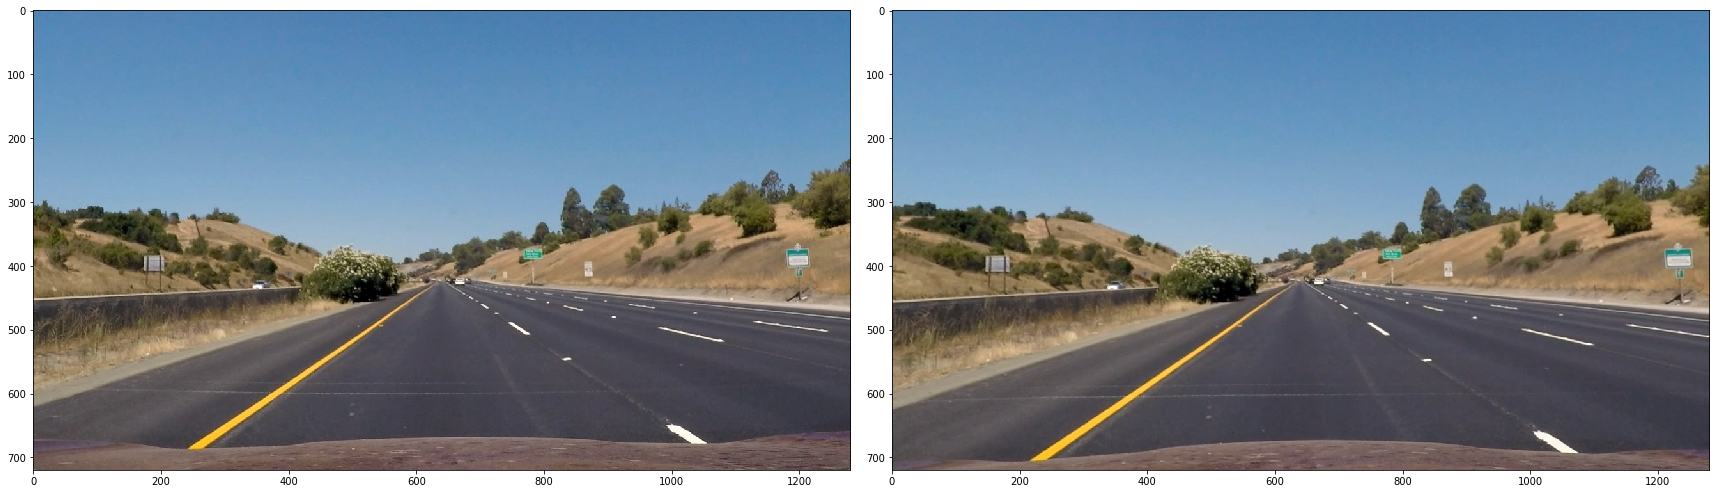

In [8]:
src_img = mpimg.imread('test_images/straight_lines1.jpg')

undist_img = undistort(src_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(src_img)
ax2.imshow(undist_img);

### Perspective transform

A perspective transform requires a transformation matrix which can be computed using the `cv2.getPerspectiveTransform()` function (*code cell 12, line 2*). This function takes 4 source points and 4 destination points as input and returns the transformation matrix. The source points are manually chosed based on a zoomed image.
Since the region of interest represents a rectangle on the road, the destination points are chosen to form a rectange as well. With the selected points, a perspective transform can be performed, which leads to a bird's eye view.
In case of changing source and image points before passing them to the `cv2.getPerspectiveTransform()` function, the output is a matrix for transforming from bird's eye view back to the original perspective (*code cell 12, line 3*).

The transform is performed using the `cv2.warpPerspective()` function (*code cell 14, line 2*), which takes the image and the transformation matrix as inputs and returns the transformed ("warped") image. An example of a transformed image is shown below. Since the lane lines appear parallel on the warped image, the transform is assumed to work properly.

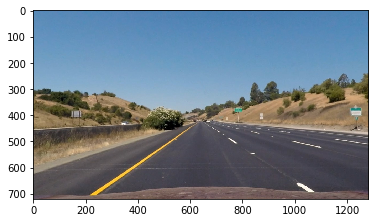

In [9]:
# show undistorted image to determine source points
# matplotlib notebook command enables zoom and mouse coordinates
# %matplotlib notebook
show_img(undist_img)

[[[  580.   460.]]

 [[  700.   460.]]

 [[ 1100.   720.]]

 [[  200.   720.]]]


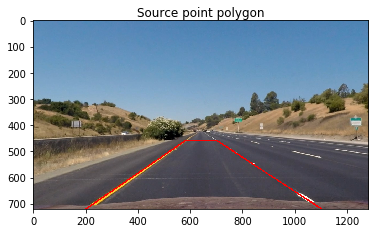

In [10]:
# %matplotlib inline
# source points manually determined from undistorted test image "straight_lines1.jpg"
src_pts = np.array([[580, 460], [700, 460], [1100, rows], [200, rows]], 
                   np.float32).reshape((4, 1, 2))
print(src_pts)

# show undistorted image with source area
undist_img_src = np.copy(undist_img)
draw_lines_from_points(undist_img_src, src_pts)
show_img(undist_img_src, None, 'Source point polygon')

In [11]:
# destination points for perspective transformation
lane_dist = 700 # in pixels
mid_pnt = cols//2
dst_pts = np.array([[mid_pnt - lane_dist/2, 0], [mid_pnt + lane_dist/2, 0], 
                    [mid_pnt + lane_dist/2, rows], [mid_pnt - lane_dist/2, rows]], 
                   np.float32).reshape((4, 1, 2))
print(dst_pts)

[[[ 290.    0.]]

 [[ 990.    0.]]

 [[ 990.  720.]]

 [[ 290.  720.]]]


In [12]:
# compute perspective transform matrix and inverse matrix
warp_mtx = cv2.getPerspectiveTransform(src_pts, dst_pts)
warp_inv_mtx = cv2.getPerspectiveTransform(dst_pts, src_pts)
print('transformation matrix:\n', warp_mtx)
print('inverse transformation matrix:\n', warp_inv_mtx)

transformation matrix:
 [[ -5.55555556e-01  -1.50244200e+00   9.85726496e+02]
 [  0.00000000e+00  -1.97802198e+00   9.09890110e+02]
 [  2.93511629e-19  -2.38095238e-03   1.00000000e+00]]
inverse transformation matrix:
 [[  1.71428571e-01  -7.68518519e-01   5.30285714e+02]
 [  4.58932415e-17  -5.05555556e-01   4.60000000e+02]
 [  2.24588775e-19  -1.20370370e-03   1.00000000e+00]]


In [13]:
# define warp function
def warp(img):
    warped_img = cv2.warpPerspective(img, warp_mtx, (cols, rows), flags=cv2.INTER_LINEAR)
    return warped_img

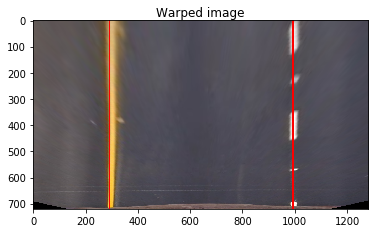

In [14]:
# perform perspective transformation
warped_img = cv2.warpPerspective(undist_img, warp_mtx, (cols, rows), flags=cv2.INTER_LINEAR)

# draw lines on warped image and plot
warped_img_roi = np.copy(warped_img)
draw_lines_from_points(warped_img_roi, dst_pts)
show_img(warped_img_roi, None, 'Warped image')

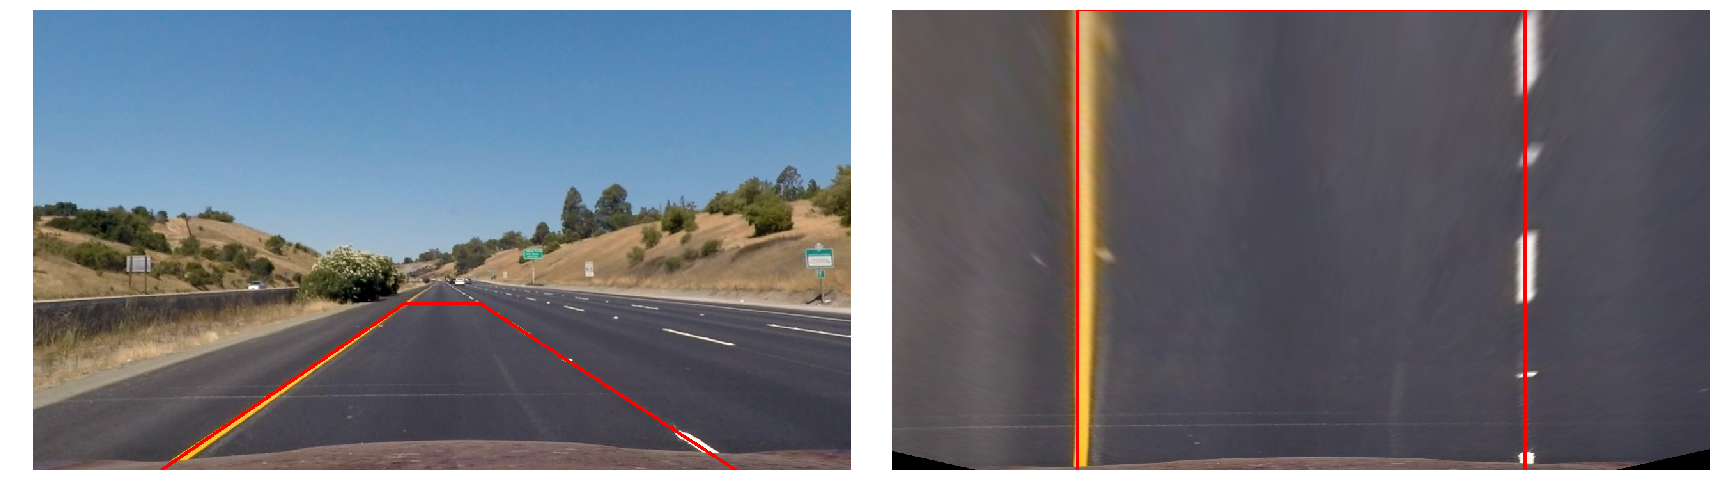

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist_img_src)
ax1.axis('off')
ax2.imshow(warped_img_roi)
ax2.axis('off');

In [16]:
# define unwarp function
def unwarp(img):
    unwarped_img = cv2.warpPerspective(img, warp_inv_mtx, (cols, rows), flags=cv2.INTER_LINEAR)
    return unwarped_img

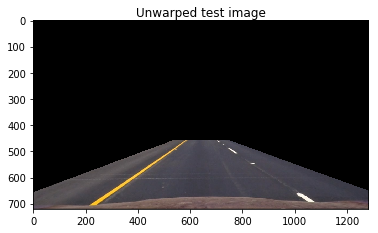

In [17]:
unwarped_test_img = unwarp(warped_img)
show_img(unwarped_test_img, None, 'Unwarped test image')

### Creation of a thresholded binary image using color transforms and gradients

To create a thresholded binary image, a combination of gradients and color transforms has been used. Both methods are described below.

#### Gradients

For creating a binary gradient image, the function `grad_thresh()` was defined (*code cell 18*). It first transforms the RGB image into a grayscale with `cv2.cvtColor()` (*code cell 18, line 7*), and then applies the [sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) by using `cv2.Sobel()` (*code cell 18, line 9-12*), to get an image of the gradient in either x or y direction. The sobel function takes a grayscale image, the required datatype, the direction and the kernel size as input arguments.  
Since the output of the sobel function can be both positive and negative (depending on if the transition is from bright-to-dark or from dark-to-bright), a high, signed datatype of float 64 (cv2.CV_64F) is used first [openCV documentation](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_gradients/py_gradients.html). After calculating the absolute value (so both edges can be found), the image is converted to 8-bit unsigned integer.  
Since the lane lines are assumed to appear mostly vertical in the warped images, only the gradient in x direction was used. A kernel size of 3 provided good detection results.

To get the binary image, a blank one-channel image with the x and y dimensions of the original image is created first (*code cell 18, line 17*). Then the threshold is applied by setting the blank image to 1 where the values of the gradient image are above the low threshold and below the high threshold values.


#### Color transforms

To create a color threshold binary image, both [RGB](https://en.wikipedia.org/wiki/RGB_color_model) (Red, Green, Blue) and [HLS](https://en.wikipedia.org/wiki/HSL_and_HSV) (Hue, Saturation, Lightness) color spaces are used. The function `rbg_color_thresh()` (*code cell 20*) is defined to create a binary image based on the RGB channels, while  `hls_color_thresh()` (*code cell 21*) does the same for an HLS image.  

In both cases a blank image is created first and set to 1 where the value of the color channel is above the low threshold and below the high threshold (as with the binary gradient image before). For the binary HLS image, the original RGB image must be converted to HLS, of course (`cv2.cvtColor()`, *code cell 21, line 4*).

#### Combination

To combine color and gradient binary images, the function `create_bin_img()` (*code cell 24*) is defined, which uses bitwise operations on images. Good results have been achieved by using the following bitwise combination:

RGB-Red **OR (** HLS-Saturation **AND** HLS-Hue **) OR** Gradient

An example of the binary combined color image and gradient image is shown below.

In [18]:
# define gradient threshold function
def grad_thresh(img, orient='x', 
                kernel = 3, thresh=(0, 255)):
    """Creates thresholded binary image based on directional 
    gradient"""
    # convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # take derivative in 'orient' direction
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    # calculate absolute value and scale to 8-bit
    abs_sobel = np.abs(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))
    # create binary image
    grad_bin = np.zeros_like(scaled_sobel)
    grad_bin[(scaled_sobel >= thresh[0]) & 
                (scaled_sobel <= thresh[1])] = 1
    # return binary image
    return grad_bin

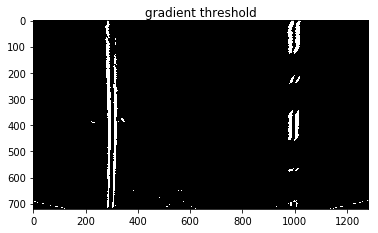

In [19]:
# create and plot gradient threshold image
bin_grad_img = grad_thresh(warped_img, 'x', 
                          kernel = 3, thresh = (20, 255))
plt.imshow(bin_grad_img, cmap = 'gray')
plt.title('gradient threshold');

In [20]:
# define rgb color threshold function
def rgb_color_thresh(img, ch, thresh=(0, 255), show=False):
    if ch=='r':
        chnl = img[:,:,0] # r channel
    if ch=='g':
        chnl = img[:,:,1] # g channel
    if ch=='b':
        chnl = img[:,:,2] # b channel
        
    if show==True:
        show_img(chnl, 'gray', ch)

    # apply threshold
    rgb_col_bin = np.zeros_like(img[:,:,2])
    rgb_col_bin[(chnl > thresh[0]) & (chnl <= thresh[1])] = 1
    
    return rgb_col_bin

In [21]:
# define hls color threshold function
def hls_color_thresh(img, ch, thresh=(0, 255), show=False):
    # convert image to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    if ch=='h':
        chnl = hls[:,:,0] # h channel
    if ch=='l':
        chnl = hls[:,:,1] # l channel
    if ch=='s':
        chnl = hls[:,:,2] # s channel
        
    if show==True:
        show_img(chnl, 'gray', ch)

    # apply threshold
    hls_col_bin = np.zeros_like(hls[:,:,2])
    hls_col_bin[(chnl > thresh[0]) & (chnl <= thresh[1])] = 1
    return hls_col_bin

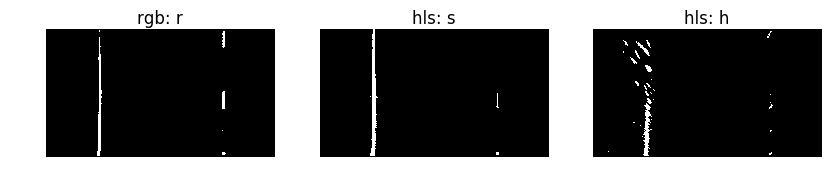

In [22]:
r_bin = rgb_color_thresh(warped_img, 'r', thresh = (220, 255), show=False)
s_bin = hls_color_thresh(warped_img, 's', thresh = (130, 255), show=False)
h_bin = hls_color_thresh(warped_img, 'h', thresh = (19, 50), show=False)

col_bin = (r_bin, s_bin, h_bin)
cmaps = (['gray']*3)
show_imgs(col_bin, cmaps, (['rgb: r','hls: s','hls: h']), 1,3)

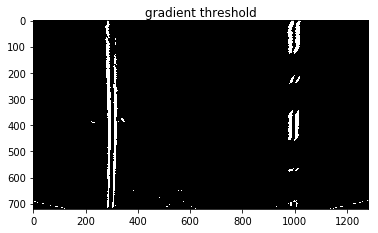

In [23]:
# gradient
grad_bin = grad_thresh(warped_img, 'x', 3, [20,255])
show_img(grad_bin, 'gray', 'gradient threshold')

In [24]:
def create_bin_img(warped_img):
    # color
    r_col_bin = rgb_color_thresh(warped_img, 'r', thresh = (220, 255), show=False)
    s_col_bin = hls_color_thresh(warped_img, 's', thresh = (130, 255), show=False)
    h_col_bin = hls_color_thresh(warped_img, 'h', thresh = (17, 50), show=False)
    # gradient
    grad_bin = grad_thresh(warped_img, 'x', 3, [20,255])

    # combined binary threshold image
    bin_img = np.zeros_like(r_col_bin)
    bin_img[(r_col_bin==1) | ( (s_col_bin==1) & (h_col_bin==1) ) | grad_bin==1] = 1

    return bin_img

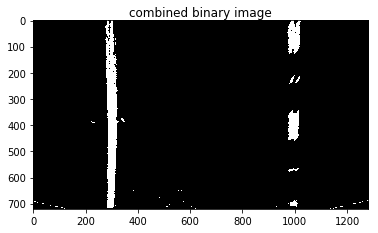

In [25]:
bin_img = create_bin_img(warped_img)
show_img(bin_img, 'gray', 'combined binary image')

In [26]:
def create_mult_bin_imgs(warped_img):
    # color threshold
    r_col_bin = rgb_color_thresh(warped_img, 'r', thresh = (220, 255), show=False)
    s_col_bin = hls_color_thresh(warped_img, 's', thresh = (130, 255), show=False)
    h_col_bin = hls_color_thresh(warped_img, 'h', thresh = (17, 50), show=False)
    comb_col_bin = cv2.bitwise_and(s_col_bin, h_col_bin)
    col_bin_img = cv2.bitwise_or(r_col_bin, comb_col_bin)
    
    # gradient threshold
    grad_bin_img = grad_thresh(warped_img, 'x', 3, [20,255])

    # combined color and gradient threshold binary image
    bin_img = cv2.bitwise_or(col_bin_img, grad_bin_img)
    
    return (col_bin_img, grad_bin_img, bin_img)

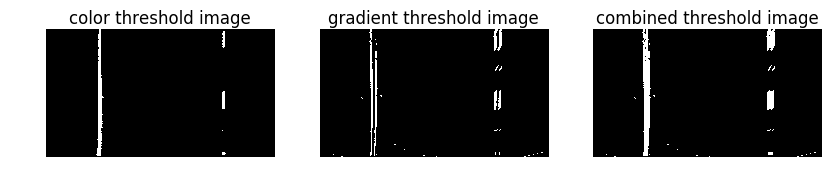

In [27]:
col_bin_img, grad_bin_img, bin_img = create_mult_bin_imgs(warped_img)
cmaps=['gray','gray','gray']
ttls=['color threshold image', 'gradient threshold image', 'combined threshold image']
show_imgs([col_bin_img, grad_bin_img, bin_img],cmaps,ttls,1,3)

### Identification of lane-line pixels polynomial fit

To identify lane-line pixels, two different methods are used. First, a sliding window approach is applied, which returns the pixel values of potential lane-lines. After fitting a polynomial and a check if the result is plausible, a more efficient proximity search around the previous fit is performed in the next frame. Both methods are described below.

#### Sliding window search

The `sliding_window()` function is defined in *code cell 30*. The method starts with calculating a histgram, which sums up the number of pixels in every column for the lower half of the binary image. An example histogram is shown below. After splitting the histogramm into left and right for both lines (*code cell 30, line 9*), its left and right maximum values are used as starting points for the sliding windows (*code cell 30, line 11-14*), since it is likely to find the lines in this area. The image is searched from bottom to top with the sliding windows, which are adapted horizontally if the mean values of the detected pixels change (*code cell 30, line 44-52*). Since the method is implemented with a for loop, it is relatively inefficient.


#### Proximity search

To avoid the relatively slow sliding window search, `proximity_search()` is applied if possible, which is defined in *code cell 37*. The use of the function requires, that a line was found and successfully fit in the frame before, since the fitted polynomial is used for this method. It searches the lines only in the area of the fitted polynomial from the previous frame and returns its pixel values.

#### Polynomial fit

To fit a polynomial, the function `fit_poly()` is defined (*code cell 34*). It basically uses the `np.polyfit()` function to fit a 2nd order polynomial and return its coefficients (*code cell 34, line 6*). Since the lane-lines are assumed to be vertical in the transformed images, x and y are switched here.
After creating the y and x values of the polynomial (*line 9-10*), the x values are limited in case of a fit that exceeds the image bounds (*line 13-14*).

In [28]:
def draw_win(img, win_x, win_y):
    # draw windows on image 
    return None

In [29]:
# number of sliding windows
n_win = 9
# windows width (+/-margin)
margin = 100
# min number of pixels to recenter window
min_pix = 50
# set window height
win_h = np.int(img.shape[0]//n_win)

In [30]:
def sliding_window(img, side, show_win=False):
    
    if debug_mode: print('sliding windows, ', side)
        
    # create histogramm from bottom half of the image
    hist = np.sum(img[img.shape[0]//2:, :], axis = 0)
    if debug_mode: plt.plot(hist); plt.show()
    # find midpoint
    mid_pnt = np.int(hist.shape[0]//2)
    # find left and right windows start positions based on peaks in histogram
    if side=='left':
        x_start = np.argmax(hist[:mid_pnt])
    if side=='right':
        x_start = np.argmax(hist[mid_pnt:]) + mid_pnt
    # if no line is detected
    if (x_start==0 | x_start== mid_pnt):
        x_start = -1
    
    # find x and y positions of all nonzero pixels
    nonzero_y = np.array(img.nonzero()[0])
    nonzero_x = np.array(img.nonzero()[1])
    
    # initialize current window positions with start values from histogram
    x_current = x_start
    
    # initialization of empty lists for lane pixel indices
    lane_inds = []

    # create 3 channel image
    out_img = np.dstack((img, img, img))*255
    
    # loop through all windows
    for win in range(n_win):
        
        # determine window y boundaries
        winy_low = img.shape[0] - (win + 1) * win_h
        winy_high = img.shape[0] - win * win_h -1
        winy = np.array([winy_low, winy_high])
        # determine window x boundaries
        winx_low = x_current - margin
        winx_high = x_current + margin
        winx = np.array([winx_low, winx_high])
        
        # find nonzero pixels in x and y within current window
        good_inds = ((nonzero_y >= winy[0]) & (nonzero_y < winy[1]) & 
                                  (nonzero_x >= winx[0]) & (nonzero_x < winx[1])).nonzero()[0]

        # append the indices to the lists
        lane_inds.append(good_inds)
        
        # if pixels in window > minpix pixels, recenter next window on their mean position
        if np.count_nonzero(good_inds) > min_pix:
            x_current = np.uint16(np.mean(nonzero_x[good_inds]))

        # draw sliding windows
        if show_win==True:
            cv2.rectangle(out_img, (winx[0], winy[0]), (winx[1], winy[1]), (0, 255, 0), 2)
        
    try:
        # create one array of indices out of the list of lists
        lane_inds = np.concatenate(lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
        
    # Extract left and right line pixel positions
    x = nonzero_x[lane_inds]
    y = nonzero_y[lane_inds] 
    
    ## Visualization ##
    # Colors in the left and right lane regions
    if side=='left':
        out_img[y, x] = [255, 0, 0]
    if side=='right':
        out_img[y, x] = [0, 0, 255]
    
    # display the output
    if show_win==True:
        show_img(out_img)
    
    return (x, y)

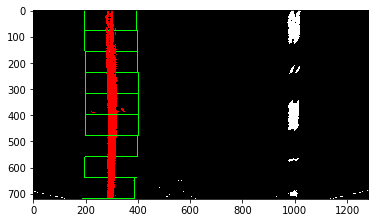

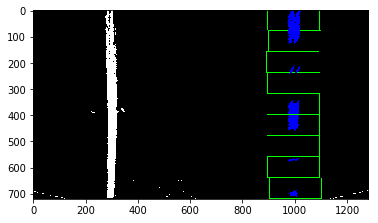

In [31]:
leftx, lefty = sliding_window(bin_img, 'left', True)
rightx, righty = sliding_window(bin_img, 'right', True)

In [32]:
def mark_linepix_on_bin_img(bin_img, leftx,lefty,rightx,righty):
    
    out_img = np.zeros((rows, cols, channels), dtype=np.uint8)
    out_img = np.dstack([bin_img, bin_img, bin_img])*255

    out_img[lefty,leftx,1]=0
    out_img[lefty,leftx,2]=0

    out_img[righty,rightx,0]=0
    out_img[righty,rightx,1]=0
    
    return out_img

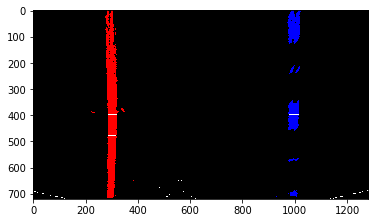

In [33]:
leftx, lefty = sliding_window(bin_img, 'left', False)
rightx, righty = sliding_window(bin_img, 'right', False)

out_img = mark_linepix_on_bin_img(bin_img, leftx,lefty,rightx,righty)
show_img(out_img)

In [34]:
def fit_poly(img, side, x, y, show=False):
    
    if debug_mode: print('fit poly, ', side)
            
    # Fit a second order polynomial to each using `np.polyfit`
    fit = np.polyfit(y, x, 2)

    # generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0], dtype=int)
    fitx = (fit[0]*ploty**2 + fit[1]*ploty + fit[2]).astype(int)

    # limit values that are out of bounds
    fitx[fitx<0]=0
    fitx[fitx>cols-1]=cols-1

    # plots the fitted polynomial
    if show==True:
        plt.plot(fitx, ploty, color='yellow')

    return (fit, ploty, fitx)

In [35]:
def draw_poly(img, left_fitx, right_fitx, ploty, leftcol=[255,0,0], rightcol=[0,0,255]):
    
    left_pts = np.vstack([left_fitx, ploty]).T
    right_pts = np.vstack([right_fitx, ploty]).T

    cv2.polylines(img, ([left_pts]), False, leftcol,thickness=10)
    cv2.polylines(img, ([right_pts]), False, rightcol,thickness=10)
    
    return img

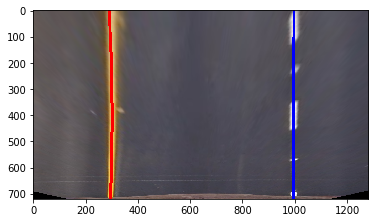

In [36]:
left_fit, ploty, left_fitx = fit_poly(bin_img, 'left', leftx, lefty, show=False)
right_fit, ploty, right_fitx = fit_poly(bin_img, 'right', rightx, righty, show=False)

poly_img = draw_poly(warped_img, left_fitx, right_fitx, ploty)

show_img(poly_img)

In [37]:
def proximity_search(img, side, fit):
    
    if debug_mode: print('proximity search, ', side)
    
    nonzero_y = np.array(img.nonzero()[0])
    nonzero_x = np.array(img.nonzero()[1])
    
    lane_inds = ((nonzero_x > (fit[0]*(nonzero_y**2) + fit[1]*nonzero_y + fit[2] - margin)) & 
                 (nonzero_x < (fit[0]*(nonzero_y**2) + fit[1]*nonzero_y + fit[2] + margin)))
    
    x = nonzero_x[lane_inds]
    y = nonzero_y[lane_inds] 
    
    return (x, y)

### Radius of lane curvature and the position of the vehicle with respect to the lane center

The radius of a curve is calculated by using
$R_{curve} = \frac{\big[1 + (\frac{dy}{dx})²\big]^{3/2}}{\lvert\frac{d²y}{dx²}\rvert}$ [\[https://www.intmath.com\]](https://www.intmath.com/applications-differentiation/8-radius-curvature.php).

Assuming the 2nd order polynomial curve $f(y) = Ay² + By + C$ and their derivatives $f'(y) = 2Ay + B$ and $f''(y) = 2A$, this leads to

$R_{curve} = \frac{\big[1 + (2 Ay + B)²\big]^{3/2}}{\lvert2A\rvert}$.
This formular is used in the `get_radius()` function *code cell 39, line 6-8*. The radius is calculated at the bottom of the image, since this is the closest approximation to the current position of the car.

The distance to the lane center results from the difference between the calculated lane center and the middle of the image, which can be seen in function `get_offset()` (*code cell 40, line 4-8*). By definition, a negative offset means a car position left from the lane center.

For converting the measures from pixel to real world space, conversion coefficients for x and y directions are required (`xm_per_pix` and `ym_per_pix` in *code cell 38, line 8 and 15*). Their values have been determined based on the warped image above, assuming a lane width of 3.7 meters and a dashed line length of 3 meters.

In [38]:
# Converting from pixel space to real world space
dashed_line_length_in_m = 3
num_dashed_lines_roi = 6.1
# lane area length in meters
roi_h_in_m = np.round(dashed_line_length_in_m*num_dashed_lines_roi,2)
# lane area length in pixels
roi_h_in_pixels = 720
ym_per_pix = roi_h_in_m/roi_h_in_pixels
print('ym_per_pix = ', roi_h_in_m, '/', roi_h_in_pixels)

# lane width in meters
lane_w_in_m = 3.7
# lane width in pixels
lane_w_in_pix = np.abs(right_fitx[-1]-left_fitx[-1])
xm_per_pix = lane_w_in_m/lane_w_in_pix
print('xm_per_pix = ', lane_w_in_m, '/', lane_w_in_pix,'\n')

ym_per_pix =  18.3 / 720
xm_per_pix =  3.7 / 697 



In [39]:
# define function for calculating the curvature radius
def get_radius(x_vals, y_vals):
    """the function takes x and y values of detected lines in pixel units as input 
    and returns the radius in meters"""
    real_fit = np.polyfit(y_vals*ym_per_pix, x_vals*xm_per_pix, 2)
    
    num = (1 + (2*real_fit[0]*np.max(y_vals)*ym_per_pix + real_fit[1])**2)**(3/2)
    denum = np.abs(2*real_fit[0])
    radius = num/denum
    
    return radius

In [40]:
# define function for calculating the distance from the car to the lane center
def get_offset(left_fit_x, right_fit_x):
    """the function takes x and y values of the fitted lines as input
    and returns the distance from the middle of the car to the lane center in meters"""
    lane_mid = np.mean([left_fit_x[-1], right_fit_x[-1]])
    center = cols//2
    # negative value means car is left from center
    offset = (center - lane_mid)*xm_per_pix
        
    return offset

In [41]:
# apply the radius and offset function
left_radius = get_radius(left_fitx, ploty)
right_radius = get_radius(right_fitx, ploty)
radius = np.mean([left_radius, right_radius])
print(radius)

offset = get_offset(left_fitx, right_fitx)
print(offset)

9891.45782134
-0.0132711621234


#### Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

In [42]:
def plot_txt(img):
        
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    font_size = 1.5
    thickness = 3
    
    # check if detection of valid lines has failed
    if l_line.fail_flag==True:
        cv2.putText(img, 'l rad: {:.2f}m, r rad: {:.2f}m, dist: {:.2f}m'.format(l_line.curverad,r_line.curverad,l_line.offset), (100,140), font_face, 
                    font_size, (255,0,0), thickness)
    else:
        pos_rad = (100, 100)
        pos_off = (100, 180)
        radius = np.mean([l_line.avg_curverad, r_line.avg_curverad])
        cv2.putText(img, 'curvature radius: {:.2f}m'.format(radius), pos_rad, font_face, 
                    font_size, (255,255,255), thickness)
        
        if l_line.avg_offset<0:
            cv2.putText(img, 'Vehicle pos: {:.2f}m left from center'.format(np.abs(l_line.avg_offset)), pos_off, font_face, 
                        font_size, (255,255,255), thickness)
        else:
            cv2.putText(img, 'Vehicle pos: {:.2f}m right from center'.format(np.abs(l_line.avg_offset)), pos_off, font_face, 
                        font_size, (255,255,255), thickness)


In [43]:
def line_distance(left_fit_x, right_fit_x):
     # calculate line distane
    bottom_dist = (right_fit_x[rows-1] - left_fit_x[rows-1])*xm_per_pix
    middle_dist = (right_fit_x[rows//2] - left_fit_x[rows//2])*xm_per_pix
    top_dist = (right_fit_x[0] - left_fit_x[0])*xm_per_pix
    return np.mean([bottom_dist, middle_dist, top_dist])

In [44]:
def sanity_check(left_rad, right_rad, left_fit_x, right_fit_x):
    
    if debug_mode: print('sanity check')
    
    distance = line_distance(left_fit_x, right_fit_x)
    
    # check if left and right lines have similar curvature or line distance is plausible (approx 3.7m)
    if (np.abs(left_rad - right_rad) < 1100) | (np.abs(distance - 3.7) < 1):
        if debug_mode: print('sanity check passed')
        return True
        
    else: # sanity check failed
        if debug_mode: 
            print('sanity check failed:')
            print('left_rad: ', l_line.curverad, ', right_rad:', r_line.curverad, ', distance: ', dist)
        return False

In [45]:
def update_line(res, line_obj, pix_x, pix_y, fit, fit_x, ploty, radius, offset):
    if debug_mode: print('update_line')
        
    # if sanity check passed
    if res==True:
        # update line object
        line_obj.fail_count = 0
        line_obj.fail_flag = False
        line_obj.fit_x = fit_x
        line_obj.list_fit_x.append(fit_x)
        line_obj.avg_fit_x = np.mean(line_obj.list_fit_x, axis=0).astype(int)
        line_obj.avg_fit = np.polyfit(ploty, line_obj.avg_fit_x, 2)
        line_obj.fit = fit
        line_obj.curverad = radius
        line_obj.list_curverad.append(radius)
        line_obj.avg_curverad = np.mean(line_obj.list_curverad)
        line_obj.offset = offset
        line_obj.list_offset.append(offset)
        line_obj.avg_offset = np.mean(line_obj.list_offset)
    # if sanity check failed
    else:
        # if maximum number of fail counts is not exceeded, increment counter and add existing mean
        # values to all deques
        if line_obj.fail_count < line_obj.histlen:
            line_obj.fail_count += 1
            line_obj.fail_flag = False
        # if maximum number of fail counts is exceeded, use current values
        if line_obj.fail_count >= line_obj.histlen:
            line_obj.fail_flag = True
            line_obj.fit_x = fit_x
            line_obj.list_fit_x = deque(maxlen=line_obj.histlen)
            line_obj.avg_fit_x = fit_x
            line_obj.avg_fit = fit
            line_obj.fit = fit
            line_obj.curverad = radius
            line_obj.list_curverad = deque(maxlen=100)#deque(maxlen=line_obj.histlen)
            line_obj.avg_curverad = None
            line_obj.offset = offset
            line_obj.list_offset = deque(maxlen=line_obj.histlen)
            line_obj.avg_offset = None
            
    return None

In [46]:
def find_line_pix(bin_img, side, line_obj):
    
    if debug_mode: print(find_line_pix);
    
    # perform sliding window search when fail counter is exceeded
    if line_obj.fail_count>=line_obj.histlen:
        x, y = sliding_window(bin_img, side)
    else:
        x, y = proximity_search(bin_img, side, line_obj.avg_fit)
    
    return x, y

In [47]:
def create_overlay(left_fitx, right_fitx, ploty):

    overlay_img = np.zeros((rows,cols,channels), dtype=np.uint8)
    
    # Generate a polygon to illustrate the search window area
    # and recast the x and y points into usable format for cv2.fillPoly()
    l_array = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    r_array = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((l_array, r_array))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(overlay_img, np.int_([line_pts]), (0,255,0))

    # draw the lane line fits 
    left_pts = np.reshape(l_array,(-1,2))
    right_pts = np.reshape(r_array,(-1,2))
    cv2.polylines(overlay_img, ([left_pts]), False, [255,0,0], thickness=20)
    cv2.polylines(overlay_img, ([right_pts]), False, [0,0,255], thickness=20)
    
    return overlay_img

In [48]:
def blend_imgs(img1, img2):
    blended_img = cv2.addWeighted(img1, 1, img2, 0.3, 0)
    return blended_img

In [49]:
def pipeline(src_img):
        
    # undistort and unwarp source image
    undist_img = undistort(src_img)
    warped_img = warp(undist_img)
    
    if debug_mode:
        col_bin_img, grad_bin_img, bin_img = create_mult_bin_imgs(warped_img)
    else:
        bin_img = create_bin_img(warped_img)
    
    # find line pixel values
    leftx, lefty = find_line_pix(bin_img, 'left', l_line)
    rightx, righty = find_line_pix(bin_img, 'right', r_line)
    
    # fit polynomials to pixel values
    left_fit, ploty, left_fit_x = fit_poly(bin_img, 'left', leftx, lefty)
    right_fit, ploty, right_fit_x = fit_poly(bin_img, 'right', rightx, righty)

    # calculate radius and offset values in meters
    left_rad = get_radius(leftx, lefty)
    right_rad = get_radius(rightx, righty)
    radius = np.mean([left_rad, right_rad])
    offset = get_offset(left_fit_x, right_fit_x)
    
    # check if lines are valid
    res = sanity_check(left_rad, right_rad, left_fit_x, right_fit_x)
    
    # update instance variables
    update_line(res, l_line, leftx, lefty, left_fit, left_fit_x, ploty, left_rad, offset)
    update_line(res, r_line, rightx, righty, right_fit, right_fit_x, ploty, right_rad, offset)

    # create and unwarp lane overlay and plot text
    overlay_img = create_overlay(l_line.avg_fit_x, r_line.avg_fit_x, ploty)
    unwarped_overlay_img = unwarp(overlay_img)
    
    final_img = blend_imgs(undist_img, unwarped_overlay_img)
    plot_txt(final_img)

    if debug_mode:
        blended_wrpd_img = blend_imgs(warped_img, overlay_img)

        warped_marked_img = mark_linepix_on_bin_img(bin_img, leftx, lefty, rightx, righty)

        bin_poly_img = draw_poly(warped_marked_img, l_line.avg_fit_x, r_line.avg_fit_x, ploty, 
                                leftcol=[255,255,0],rightcol=[255,255,0])
    
        comb_img = create_comb_img(final_img, 
                               bin_img, bin_poly_img, blended_wrpd_img, 
                               grad_bin_img, col_bin_img)
        return comb_img
    else:
        return final_img

### Run pipeline with test image

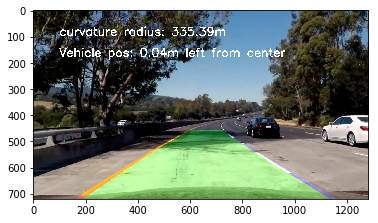

In [50]:
# read image and get size
# src_img = mpimg.imread('test_images/straight_lines1.jpg')
debug_mode=False
histlen = 1
l_line = Line(histlen)
r_line = Line(histlen)

src_img = mpimg.imread('test_images/test5.jpg')
dst_img = pipeline(src_img)
show_img(dst_img)

### Run pipeline

In [51]:
debug_mode = False

# line object instantiation
histlen = 7
l_line = Line(histlen)
r_line = Line(histlen)

In [52]:
white_output = 'output_videos/project_video.mp4'
# clip1 = VideoFileClip("project_video.mp4").subclip(35,42)
# clip1 = VideoFileClip("project_video.mp4").subclip(38,40)
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video.mp4
CPU times: user 3min 51s, sys: 8.34 s, total: 3min 59s
Wall time: 1min 41s


In [53]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [54]:
# # create .gif
sub_gif = VideoFileClip("output_videos/project_video.mp4" ).subclip(18,30)
gif_clip1 = sub_gif.resize(0.5)
gif_clip1.write_gif('output_videos/final_subclip.gif')

t:   1%|          | 2/300 [00:00<00:15, 18.90it/s, now=None]

MoviePy - Building file output_videos/final_subclip.gif with imageio.


### Debug Mode

In [60]:
# debug_mode = True

# # line object instantiation
# histlen = 7
# l_line = Line(histlen)
# r_line = Line(histlen)

In [61]:
# white_output_debug = 'output_videos/project_video_debug.mp4'
# # clip1 = VideoFileClip("project_video.mp4").subclip(35,42)
# clip1 = VideoFileClip("project_video.mp4").subclip(38,40)
# clip1_debug = VideoFileClip('project_video.mp4')
# white_clip_debug = clip1_debug.fl_image(pipeline) #NOTE: this function expects color images!!
# %time white_clip_debug.write_videofile(white_output_debug, audio=False)

In [62]:
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format(white_output_debug))

In [63]:
# # # create .gif
# sub_gif_debug = VideoFileClip("output_videos/project_video_debug.mp4" ).subclip(18,30)
# gif_clip1_debug = sub_gif_debug.resize(0.5)
# gif_clip1_debug.write_gif('output_videos/final_subclip_debug.gif')